# Load data and inspect

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [3]:
def load_face_data():
    notebook_dir = os.getcwd()
    os.chdir('../data/')
    df = pd.read_csv('icml_face_data.csv')
    os.chdir(notebook_dir)
    return df
df = load_face_data()

In [4]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Data cleaning

In [6]:
# strip spaces from column names and apply lower case
df = df.rename(columns={c:c.strip().lower() for c in df.columns})
print(df.columns)

Index(['emotion', 'usage', 'pixels'], dtype='object')


In [7]:
# convert pixels to array for ease in visualization and image preprocessing
def pixel_str_to_array(pixel_str):
    '''
    converts pixel as str separated by white spaces to an array
    '''
    pixel_array = np.array(pixel_str.split(), dtype=int)
    return pixel_array.reshape(48,48)

    
df['pixels_array'] = df['pixels'].apply(pixel_str_to_array)

In [8]:
# map emotion name
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df['emotion_nm'] = df.emotion.map(emotion_map)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   emotion       35887 non-null  int64 
 1   usage         35887 non-null  object
 2   pixels        35887 non-null  object
 3   pixels_array  35887 non-null  object
 4   emotion_nm    35887 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


# EDA

## Look at sample images
- 48*48 pixels
- almost straight-faced, grayscale images

Showing random sample images for Angry


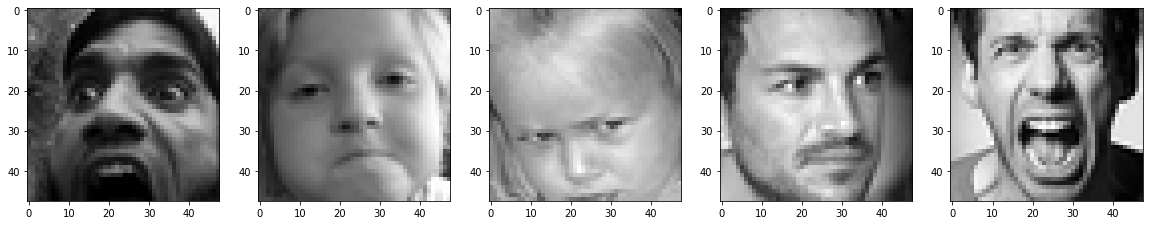

Showing random sample images for Disgust


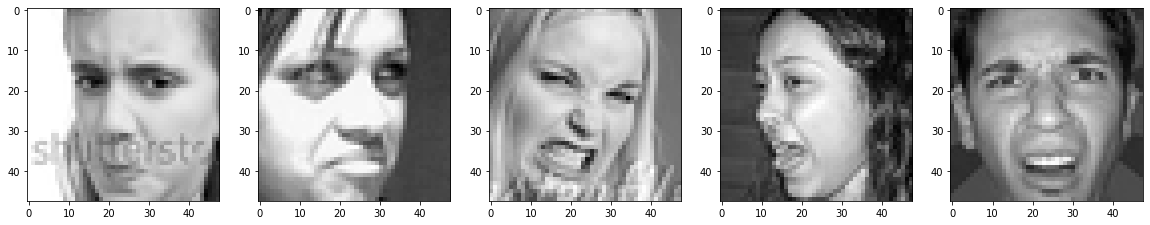

Showing random sample images for Fear


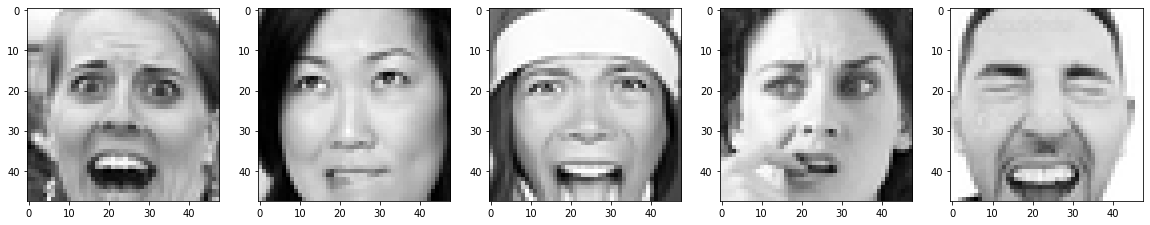

Showing random sample images for Happy


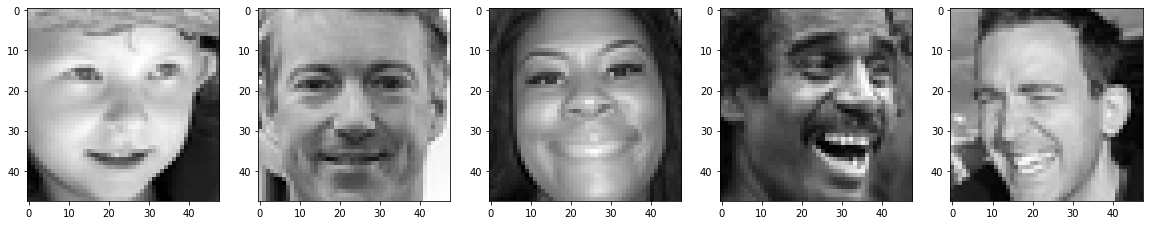

Showing random sample images for Neutral


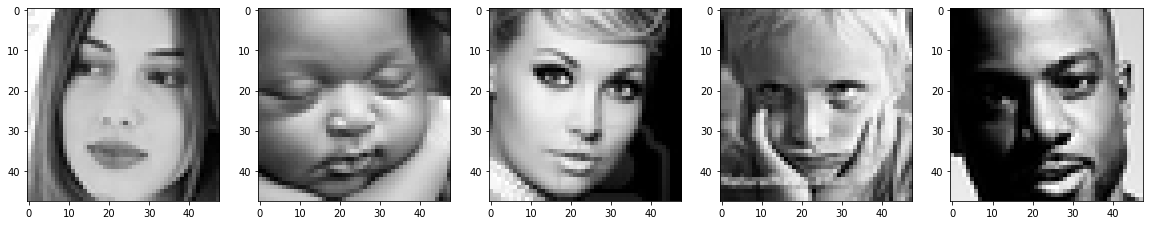

Showing random sample images for Sad


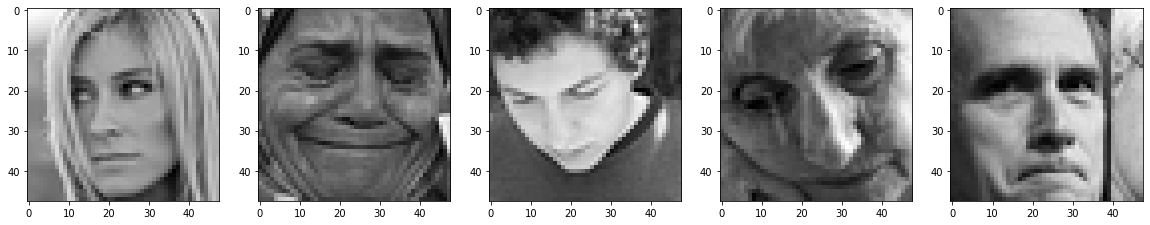

Showing random sample images for Surprise


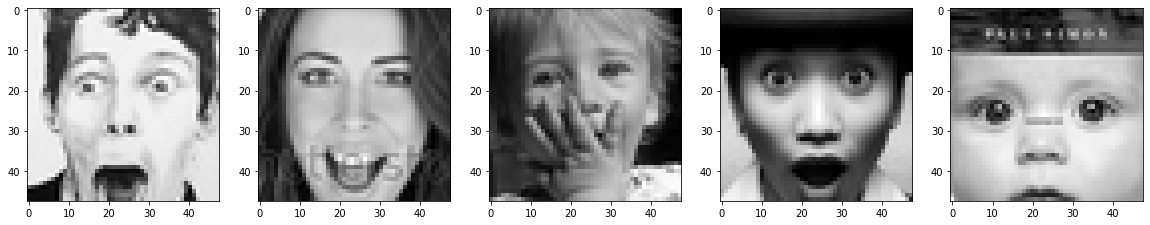

In [10]:
for emotion in sorted(df['emotion_nm'].unique()):
    print(f'Showing random sample images for {emotion}')
    n_sample = 5
    sample_imgs = df[df.emotion_nm == emotion]['pixels_array'].sample(5)
    fig, ax = plt.subplots(1, n_sample, figsize=(20,4))
    for i in range(n_sample):
        ax[i].imshow(sample_imgs.iloc[i], cmap='gray')
    plt.show()

## Emotion
- 'Disgust' has too few samples --> consider removing from model training

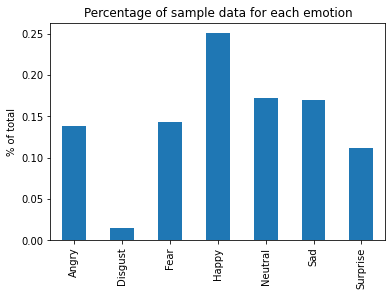

In [11]:
df['emotion_nm'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.ylabel('% of total')
plt.title('Percentage of sample data for each emotion')

plt.show()

## Usage type
- The training set consists of 28,709 examples.
- The public test set used for the leaderboard consists of 3,589 examples.
- The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

- classes are distributed in the same manner in each usage

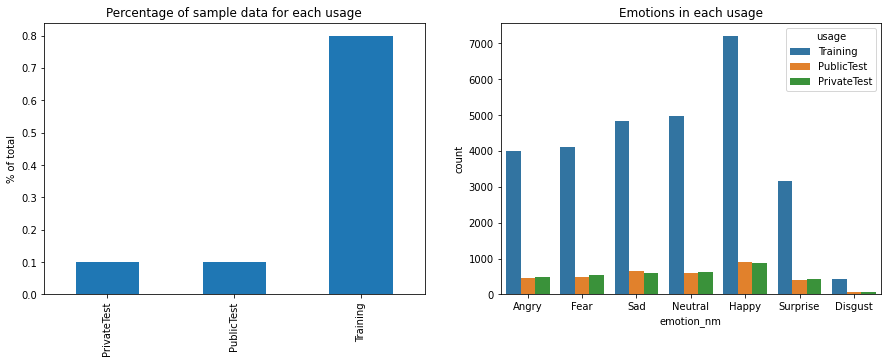

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(121)
df['usage'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.ylabel('% of total')
plt.title('Percentage of sample data for each usage')

plt.subplot(122)
sns.countplot(data=df, x='emotion_nm', hue='usage')
plt.title('Emotions in each usage')

plt.show()

# Data preprocessing

In [13]:
# separate each pixel in pixels array to one column --> to be used as features to try our basic ML models
def pixels_str_to_X(df, pixels_col='pixels'):
    '''
    convert df column of pixel str to an array to be feed into the model

    returns:
    X - array of shape (n_records, 2304)
    '''
    X = []
    for pixel_str in df[pixels_col].values:
        X.append(np.array(pixel_str.split(), dtype=int))
    return np.array(X)

def pixels_array_to_X(df, pixels_array_col='pixels_array'):
    '''
    convert df column of pixel arrays to an array to be feed into the model
    
    Inputs:
    df - dataframe holding the column
    pixels_array_col - column name in the dataframe containing img as arrays

    returns:
    X - array of shape (df.shape[0], df[pixels_array_col].values[0].shape[0], df[pixels_array_col].values[0].shape[1]) 
    '''
    n_h_w = [df.shape[0], df[pixels_array_col].values[0].shape[0], df[pixels_array_col].values[0].shape[1]] # n records, height, width
    result = np.empty(tuple(n_h_w))
    for i in range(df.shape[0]):
        result[i] = df[pixels_array_col].values[i]
    return result.reshape(tuple(n_h_w + [1]))

def emotion_to_y(df, emotions_to_classify=[], emotion_col='emotion'):
    '''
    change emotion to assign variables we want to classify and others as 0
    ex: emotions_to_classify = ['Happy'] (ie. binary classification) 
    'Happy' will have the value of 1 
    the rest will have value of 0

    ex: emotions_to_classify = ['Happy', 'Fear']
    'Happy' will have the value of 1 
    'Fear' will have the value of 2
    the rest will have value of 0

    Inputs:
    df - dataframe holding the column
    emotion_col - column name in the dataframe containing emotion names
    emotions_to_classify - list of emotions to classify

    returns:
    y - array of target values
    '''
    # emotion_nm_to_target = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Sad':4, 'Surprise':5, 'Neutral':6}
    if not emotions_to_classify:
        return df[emotion_col].values
    else:
        emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
        y = []
        for i in df[emotion_col].values:
            emotion_nm = emotion_map[i]
            if emotion_nm in emotions_to_classify:
                y.append(emotions_to_classify.index(emotion_nm) + 1)
            else:
                y.append(0)
        return np.array(y).ravel()


In [14]:
# focus on binary classification between Sad vs neutral
df_train = df[(df['emotion'].isin([4,6])) & (df['usage'] == 'Training')]
df_val = df[(df['emotion'].isin([4,6])) & (df['usage'] == 'PrivateTest')]
df_test = df[(df['emotion'].isin([4,6])) & (df['usage'] == 'PublicTest')]

In [15]:
print(df_train.shape, df_val.shape, df_test.shape)

(9795, 5) (1220, 5) (1260, 5)


## Features

In [16]:
# get X features array
# X_train_skl = pixels_str_to_X(df_train) 
# print(X_train_skl.shape)

In [17]:
# get X features array
X_train = pixels_array_to_X(df_train)
X_val = pixels_array_to_X(df_val)
X_test = pixels_array_to_X(df_test)

In [18]:
print(X_train.shape, X_val.shape, X_test.shape)

(9795, 48, 48, 1) (1220, 48, 48, 1) (1260, 48, 48, 1)


## Target

In [19]:
from keras.utils.np_utils import to_categorical

y_train = emotion_to_y(df_train, emotions_to_classify=['Sad'])
y_val = emotion_to_y(df_val, emotions_to_classify=['Sad'])
y_test = emotion_to_y(df_test, emotions_to_classify=['Sad'])

In [20]:
# one hot for multiclass classification
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_train = to_categorical(y_train)

In [21]:
print(y_train.shape, y_val.shape, y_test.shape)

(9795,) (1220,) (1260,)


## Build ImageDataGenerator
-helps with preprocessing and data augmentation

In [22]:
from keras.preprocessing.image import ImageDataGenerator
# help(ImageDataGenerator)

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_train, y_train)

In [24]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(X_val, y_val)

In [25]:
# # do we need this??
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow(X_test, y_test)

# Basic CNN

In [26]:
# instantiate model
from keras import layers
from keras import models

def get_model():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

model = get_model()

In [27]:
# configuring the model for training
from keras import optimizer_v2

model.compile(loss='binary_crossentropy', optimizer=optimizer_v2.rmsprop.RMSProp(learning_rate=0.0001), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         1

In [29]:
from keras.callbacks import EarlyStopping

history = model.fit(
    x=train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[EarlyStopping(patience=5)]
    )

Epoch 1/20
307/307 [==============================] - 22s 69ms/step - loss: 0.6900 - accuracy: 0.5335 - val_loss: 0.6808 - val_accuracy: 0.5893
Epoch 2/20
307/307 [==============================] - 20s 66ms/step - loss: 0.6731 - accuracy: 0.5879 - val_loss: 0.6566 - val_accuracy: 0.6279
Epoch 3/20
307/307 [==============================] - 20s 65ms/step - loss: 0.6534 - accuracy: 0.6152 - val_loss: 0.6425 - val_accuracy: 0.6459
Epoch 4/20
307/307 [==============================] - 18s 60ms/step - loss: 0.6410 - accuracy: 0.6383 - val_loss: 0.6343 - val_accuracy: 0.6451
Epoch 5/20
307/307 [==============================] - 17s 56ms/step - loss: 0.6308 - accuracy: 0.6459 - val_loss: 0.6266 - val_accuracy: 0.6484
Epoch 6/20
307/307 [==============================] - 17s 57ms/step - loss: 0.6203 - accuracy: 0.6607 - val_loss: 0.6231 - val_accuracy: 0.6451
Epoch 7/20
307/307 [==============================] - 17s 56ms/step - loss: 0.6110 - accuracy: 0.6739 - val_loss: 0.6134 - val_accuracy:

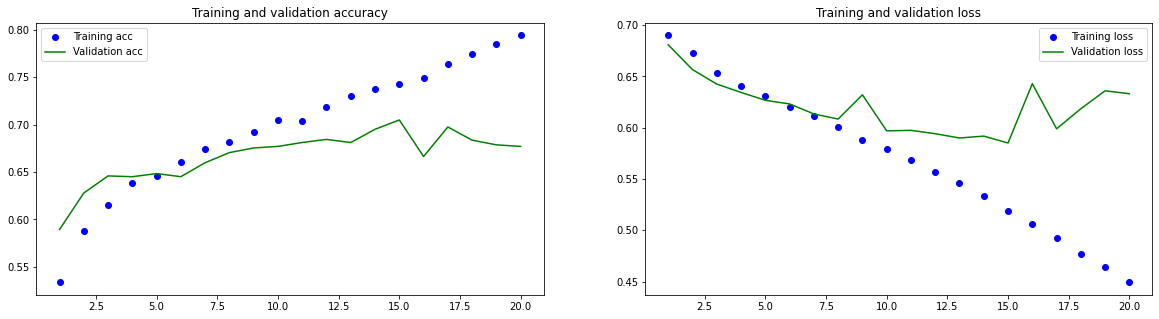

In [71]:
def plot_history(history, save_to_fname=None):
    '''
    Plots model training and validation accuracies and losses along the training epochs
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(20,5))

    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc',)
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    if save_to_fname:
        plt.savefig(save_to_fname)

    plt.show()

    
plot_history(history, 'sad_and_neutral_small_1.png')

In [31]:
# save model
model.save('sad_and_neutral_small_1.h5')

# Applying data augmentation
- in pursuit of decreasing overfitting

In [33]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )
train_generator_aug = train_datagen_aug.flow(X_train, y_train)

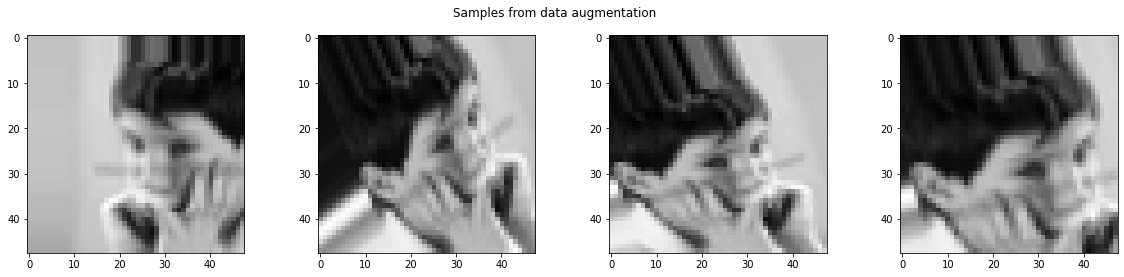

In [64]:
# visualize data augmentation
from keras.preprocessing import image

def viz_data_aug(train_datagen_aug, X_train):
    # take first instance only
    example = X_train[0].reshape((1,) + X_train.shape[1:])
    # plot data augmentation examples
    plt.figure(figsize=(20,4))
    plt.suptitle('Samples from data augmentation')

    i = 1
    for batch in train_datagen_aug.flow(example, batch_size=1):
        if i == 5:
            break
        plt.subplot(140 + i)
        i += 1
        imgplot = plt.imshow(image.array_to_img(batch[0]), cmap='gray')
    plt.show()

viz_data_aug(train_datagen_aug, X_train)

In [34]:
# validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(X_val, y_val)

In [35]:
# use same model architecture as above
model_aug = get_model()
model_aug.compile(loss='binary_crossentropy', optimizer=optimizer_v2.rmsprop.RMSProp(learning_rate=0.0001), metrics=['accuracy'])

In [67]:
history_aug = model_aug.fit(
    x=train_generator_aug,
    epochs=100,
    validation_data=val_generator,
    verbose=1,
    # callbacks=[EarlyStopping(patience=5)]
    )

# save model
model_aug.save('sad_and_neutral_small_2.h5')

Epoch 1/100
307/307 [==============================] - 18s 59ms/step - loss: 0.6136 - accuracy: 0.6604 - val_loss: 0.5880 - val_accuracy: 0.6877
Epoch 2/100
307/307 [==============================] - 19s 61ms/step - loss: 0.6102 - accuracy: 0.6697 - val_loss: 0.6220 - val_accuracy: 0.6615
Epoch 3/100
307/307 [==============================] - 16s 53ms/step - loss: 0.6080 - accuracy: 0.6639 - val_loss: 0.6340 - val_accuracy: 0.6648
Epoch 4/100
307/307 [==============================] - 17s 56ms/step - loss: 0.6063 - accuracy: 0.6693 - val_loss: 0.6348 - val_accuracy: 0.6541
Epoch 5/100
307/307 [==============================] - 18s 60ms/step - loss: 0.6067 - accuracy: 0.6671 - val_loss: 0.5926 - val_accuracy: 0.6779
Epoch 6/100
307/307 [==============================] - 17s 56ms/step - loss: 0.6024 - accuracy: 0.6718 - val_loss: 0.6247 - val_accuracy: 0.6475
Epoch 7/100
307/307 [==============================] - 17s 56ms/step - loss: 0.6037 - accuracy: 0.6743 - val_loss: 0.5885 - val_ac

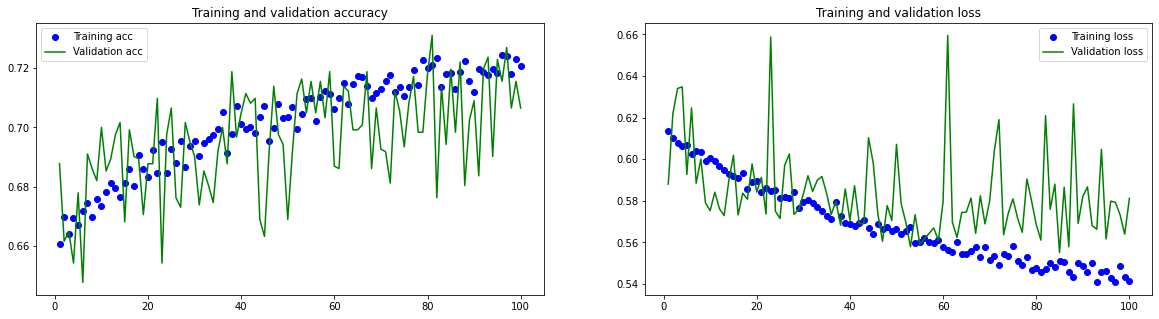

In [72]:
plot_history(history_aug, 'sad_and_neutral_small_2.png')